In [177]:
import numpy as np

Nx = 128
Ny = 16

p = np.arange(128*16)

def compute_block_indices(host_idx, host_size):
    host_idx = np.array(host_idx)

    sub_size = host_size / 2
    n_host_x = Nx // host_size
    n_host_y = Ny // host_size
    n_sub_x = Nx // sub_size
    n_sub_y = Ny // sub_size
    
    sub_block_indices = np.array([])

    for idx in host_idx:
        host_index_x = idx % n_host_x
        host_index_y = idx // n_host_x

        sub_block_indices_idx = [
            host_index_y * n_sub_x * 2 + host_index_x * 2,
            host_index_y * n_sub_x * 2 + host_index_x * 2 + 1,
            (host_index_y * 2 + 1) * n_sub_x + host_index_x * 2,
            (host_index_y * 2 + 1) * n_sub_x + + host_index_x * 2 + 1,
        ]
        sub_block_indices_idx = np.array([int(i) for i in sub_block_indices_idx])
        sub_block_indices = np.concatenate((sub_block_indices, sub_block_indices_idx))

    particle_idx = []

    for i in sub_block_indices:
        sub_index_x = i % n_sub_x
        sub_index_y = i // n_sub_x

        left_index = sub_index_x * sub_size + sub_index_y * sub_size * Nx

        particle_idx.append(int(left_index))

    return sub_block_indices, np.array(particle_idx)
host = [0, 64]
print(compute_block_indices(host, 2))
# Output: [0, 1, 32, 33, 64, 65, 96, 97]

(array([  0.,   1., 128., 129., 256., 257., 384., 385.]), array([  0,   1, 128, 129, 256, 257, 384, 385]))


In [166]:
import numpy as np

Nx = 128
Ny = 16

p = np.arange(128*16)

def compute_indices(host, local, host_size):
    host = np.array(host)
    local = np.array(local)

    assert len(local) <= 4 * len(host)
    assert max(local) <= 4 * len(host)

    sub_size = host_size / 2
    n_host_x = Nx // host_size
    n_host_y = Ny // host_size
    n_sub_x = Nx // sub_size
    n_sub_y = Ny // sub_size
    
    sub_indices = []

    
    for i in local:
        host_index = host[i // 4]
        host_index_x = host_index % n_host_x
        host_index_y = host_index // n_host_x

        host_sub_indices = [
            host_index_y * n_sub_x * 2 + host_index_x * 2,
            host_index_y * n_sub_x * 2 + host_index_x * 2 + 1,
            (host_index_y * 2 + 1) * n_sub_x + host_index_x * 2,
            (host_index_y * 2 + 1) * n_sub_x + + host_index_x * 2 + 1,
        ]
        sub_index = int(host_sub_indices[i % 4])
        sub_indices.append(sub_index)

    particle_idx = []

    for i in sub_indices:
        sub_index_x = i % n_sub_x
        sub_index_y = i // n_sub_x

        left_index = sub_index_x * sub_size + sub_index_y * sub_size * Nx

        particle_idx.append(int(left_index))

    return particle_idx
host = [0, 16, 17]
local = [0,1,2,3,4,5,6,7,8,9,10,11]
print(compute_indices(host, local, 8))
# Output: [0, 1, 32, 33, 64, 65, 96, 97]

[0, 4, 512, 516, 1024, 1028, 1536, 1540, 1032, 1036, 1544, 1548]


d_full_5.json


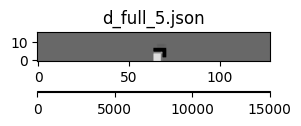

dm_full_5.json


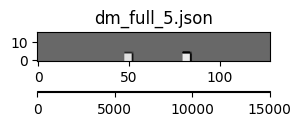

In [6]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal

Nx = 128
Ny = 16
n_particles= Nx * Ny


filenames = [
    "d_full_5.json",
    "dm_full_5.json"
    ]
for name in filenames:
    print(name)
    with open(name) as json_file:
        result = json.load(json_file)['results'][3]   
    E = np.zeros(n_particles)
    n_blocks_x = Nx
    n_blocks_y = Ny
    n_blocks = n_blocks_y * n_blocks_x
    block_nx = int(Nx / n_blocks_x)
    block_ny = int(Ny / n_blocks_y)

    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
    E = einops.rearrange(E, "(y x) -> x y", y=Ny)#.transpose()
    


    fig, axs = plt.subplots(1,1,figsize=(3,1))
    # title = str(n_blocks_x) + ' by ' + str(n_blocks_y) + ", " + obs + " observability"
    title = name


    im = axs.imshow(E.transpose(), origin='lower', cmap='Greys', vmin=0, vmax = 15000)
    axs.set_title(title)
    divider= make_axes_locatable(axs)
    cax= divider.append_axes("bottom", size="5%", pad=0.3)
    fig.colorbar(im, cax=cax, orientation='horizontal')

    plt.show()

In [216]:
with open(name) as json_file:
    result = json.load(json_file)['results'][-2]

np.unique(result)
import taichi as ti

ti.reset()
real = ti.f32
ti.init(arch=ti.cuda, default_fp=real, device_memory_GB=12)
sub_block_values = ti.field(dtype=real, shape=(2, 10), needs_grad=True)
numpyarr = np.arange(20).reshape((2,10))
sub_block_values.from_numpy(numpyarr)
sum = 0
for i in range(2):
    for j in range(10):
        sum += sub_block_values[i, j] == numpyarr[i, j]
numpyarr

[Taichi] Starting on arch=cuda


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

In [7]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]


filenames_1e4 = []
for name in filenames:
    if '10000' in name:
        filenames_1e4.append(name)



E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 128
Ny = 16
n_particles = Nx * Ny

E_d = np.zeros(n_particles)
E_g = np.zeros(n_particles)
E_h = np.zeros(n_particles)
E_v = np.zeros(n_particles)
E_d_m = np.zeros(n_particles)
E_g_m = np.zeros(n_particles)
E_v_m = np.zeros(n_particles)
E_gt = np.zeros(n_particles) + 10000
E_gt_m = np.zeros(n_particles) + 10000
E_ht = np.zeros(n_particles) + 10000

for i in range(n_particles):
    col = i % Nx
    E_d[i] = 10000
    E_g[i] = 10000
    E_h[i] = 10000
    E_v[i] = 10000
    E_d_m[i] = 10000
    E_g_m[i] = 10000
    E_v_m[i] = 10000

def discrete_damage(left, width, height):
    idx = np.array([])
    for row in np.arange(height):
        idx = np.concatenate((idx, np.arange(left+Nx*row, left+width+Nx*row)))
    
    return [int(i) for i in idx]

def gradient_damage(E, start, width, half_length, horizontal=True, E_start=1000, E_stop=10000):
    interp = np.interp(np.arange(half_length), [0, half_length-1], [E_start, E_stop])
    if horizontal:
        for row in np.arange(width):
            E[np.arange(start+Nx*row, start+half_length+Nx*row)] = interp
            E[np.arange(start+Nx*row, start-half_length+Nx*row, -1)] = interp
    else:
        for col in np.arange(width):
            E[np.arange(start+col, start+col+half_length*Nx, Nx)] = interp

def gaussian_damage(E, center, start=9000, cov=[[10, 0], [0, 10]]):
    x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
    coords = np.column_stack([x.ravel(), y.ravel()])

    dmg = multivariate_normal.pdf(coords, mean=center, cov=cov)
    dmg = dmg.reshape(E.shape)
    
    dmg = dmg / dmg.max() * start
    E = E - dmg
    return E

E_d_damage_idx = discrete_damage(64, 3, 3)
E_d[E_d_damage_idx] = np.repeat(1000, len(E_d_damage_idx))

E_d_m_damage_idx = np.concatenate((discrete_damage(48, 3, 3), discrete_damage(80, 3, 3)))
E_d_m[E_d_m_damage_idx] = np.repeat(1000, len(E_d_m_damage_idx))

gradient_damage(E_h, 64, 2, 16)
gradient_damage(E_ht, n_particles-64-Nx, 2, 16)

gradient_damage(E_v, 64, 3, 10, horizontal=False)
gradient_damage(E_v_m, 48, 3, 10, horizontal=False)
gradient_damage(E_v_m, 80, 3, 10, horizontal=False)

E_g = gaussian_damage(E_g, [64, 0])
E_g_m = gaussian_damage(E_g_m, [48, 0])
E_g_m = gaussian_damage(E_g_m, [80, 0])
E_gt = gaussian_damage(E_gt, [64, 15])
E_gt_m = gaussian_damage(E_gt_m, [48, 15])
E_gt_m = gaussian_damage(E_gt_m, [80, 15])

E_d = einops.rearrange(E_d, "(y x) -> x y", y=Ny).transpose()
E_g = einops.rearrange(E_g, "(y x) -> x y", y=Ny).transpose()
E_h = einops.rearrange(E_h, "(y x) -> x y", y=Ny).transpose()
E_v = einops.rearrange(E_v, "(y x) -> x y", y=Ny).transpose()
E_d_m = einops.rearrange(E_d_m, "(y x) -> x y", y=Ny).transpose()
E_g_m = einops.rearrange(E_g_m, "(y x) -> x y", y=Ny).transpose()
E_v_m = einops.rearrange(E_v_m, "(y x) -> x y", y=Ny).transpose()
E_gt = einops.rearrange(E_gt, "(y x) -> x y", y=Ny).transpose()
E_gt_m = einops.rearrange(E_gt_m, "(y x) -> x y", y=Ny).transpose()
E_ht = einops.rearrange(E_ht, "(y x) -> x y", y=Ny).transpose()

# fig, axs = plt.subplots(10,1, sharex=True, sharey=True, figsize=(6,14))


# fig.suptitle('Damage Cases')

# axs[0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[0].set_title('True Undamaged Elastic Field')

# axs[1].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# # axs[1].set_title('True Damaged Elastic Field')

# axs[2].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# # axs[2].set_title('True Damaged Elastic Field')

# axs[3].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# # axs[3].set_title('True Damaged Elastic Field')

# axs[4].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# # axs[4].set_title('True Damaged Elastic Field')

# axs[5].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# # axs[5].set_title('True Damaged Elastic Field')

# axs[6].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# # axs[6].set_title('True Damaged Elastic Field')

# axs[7].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

# axs[8].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


# im = axs[9].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# divider = make_axes_locatable(axs[9])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

# # im1 = axs[2, 0].imshow(E_sensor, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# # axs[2, 0].set_title('Estimated Undamaged Field, Discrete Surface Observability')
# # divider1 = make_axes_locatable(axs[2, 0])
# # cax1 = divider1.append_axes("bottom", size="5%", pad=0.3)
# # fig.colorbar(im1, cax=cax1, orientation='horizontal')

# # im2 = axs[2, 1].imshow(E_sensor_damaged, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# # axs[2, 1].set_title('Estimated Damaged Field, Discrete Surface Observability')
# # divider2 = make_axes_locatable(axs[2, 1])
# # cax2 = divider2.append_axes("bottom", size="5%", pad=0.3)
# # fig.colorbar(im2, cax=cax2, orientation='horizontal')
# plt.show()
    

    


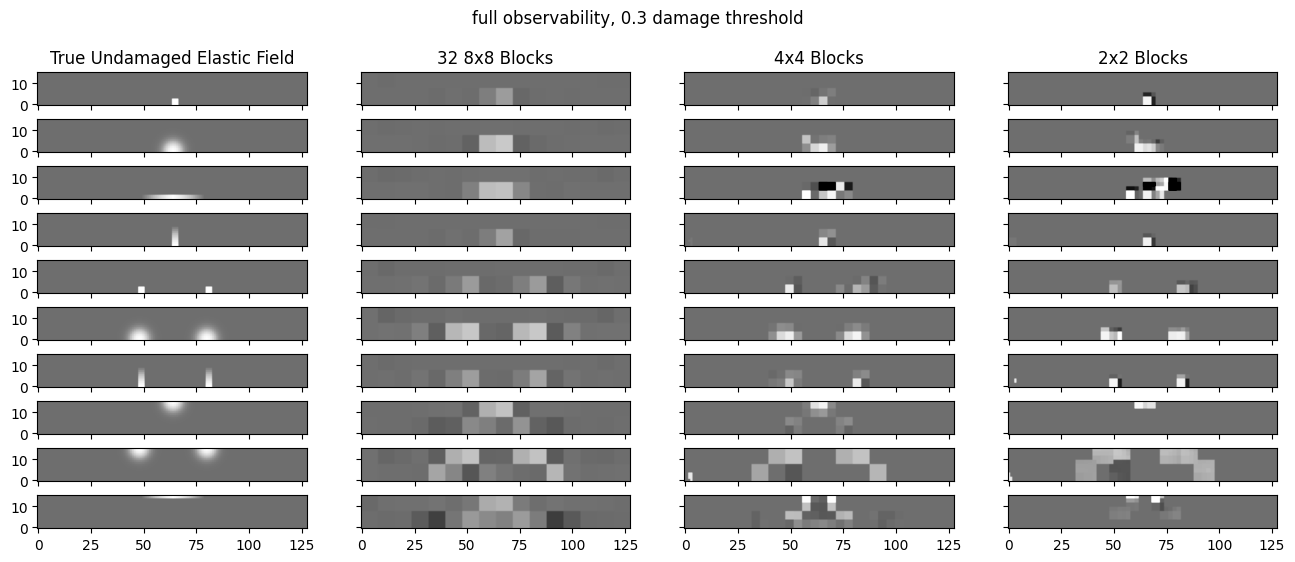

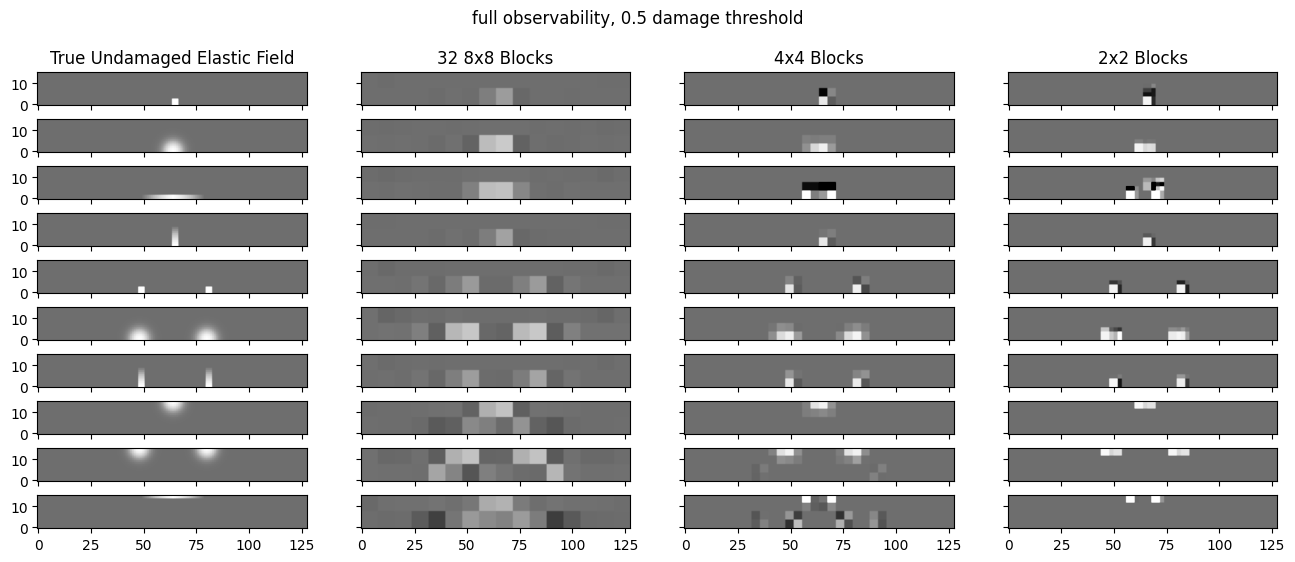

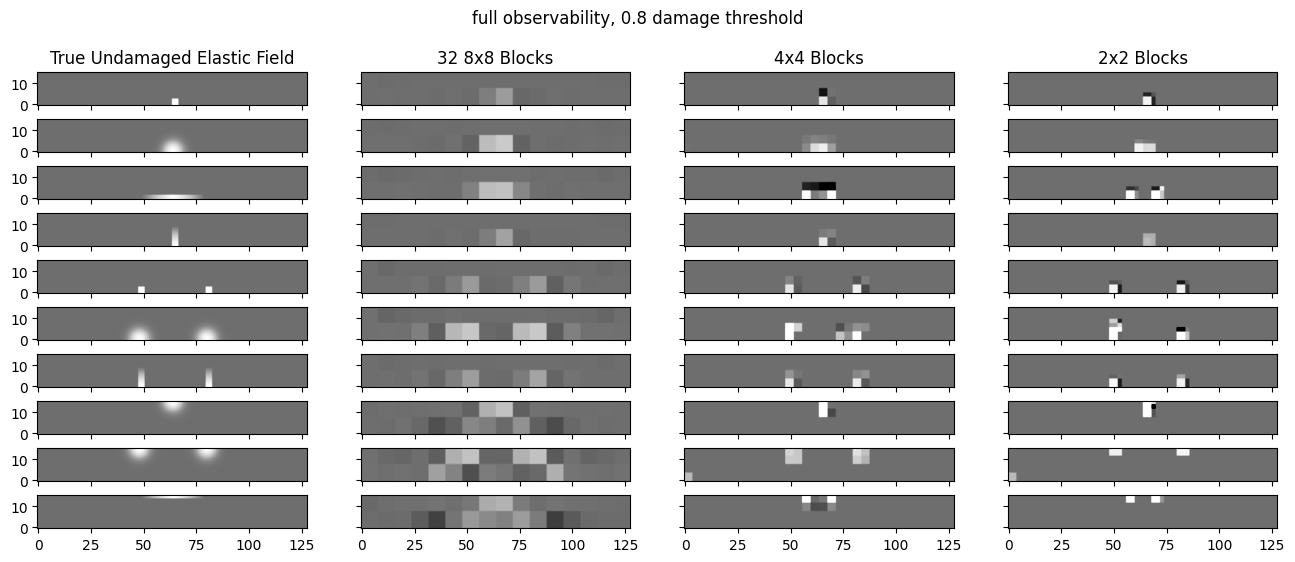

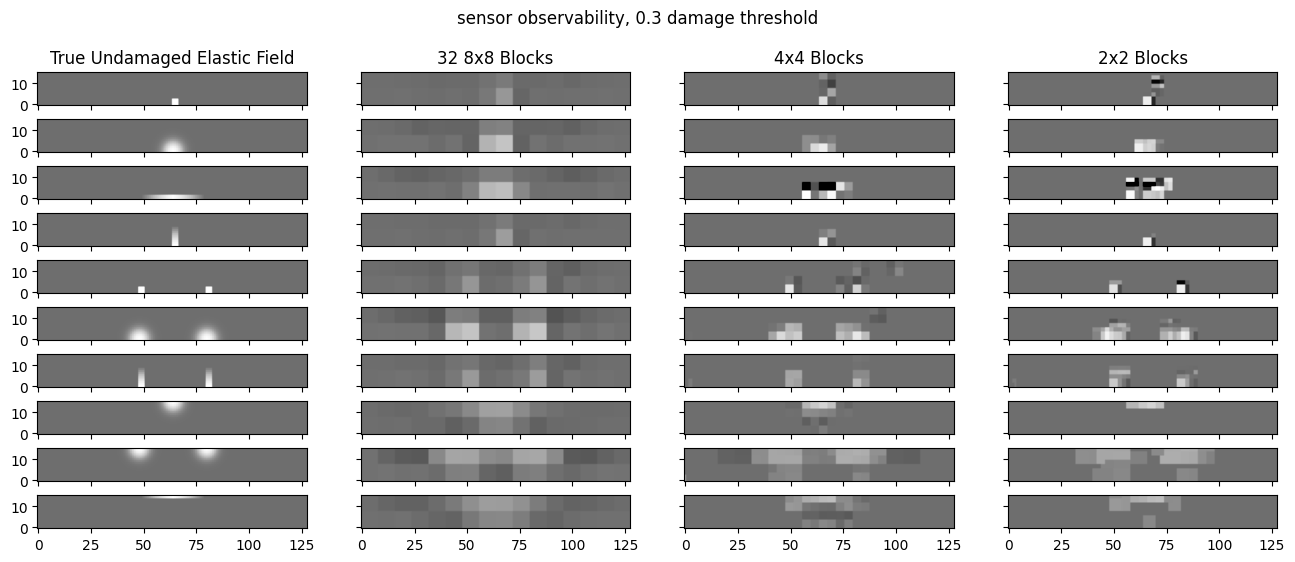

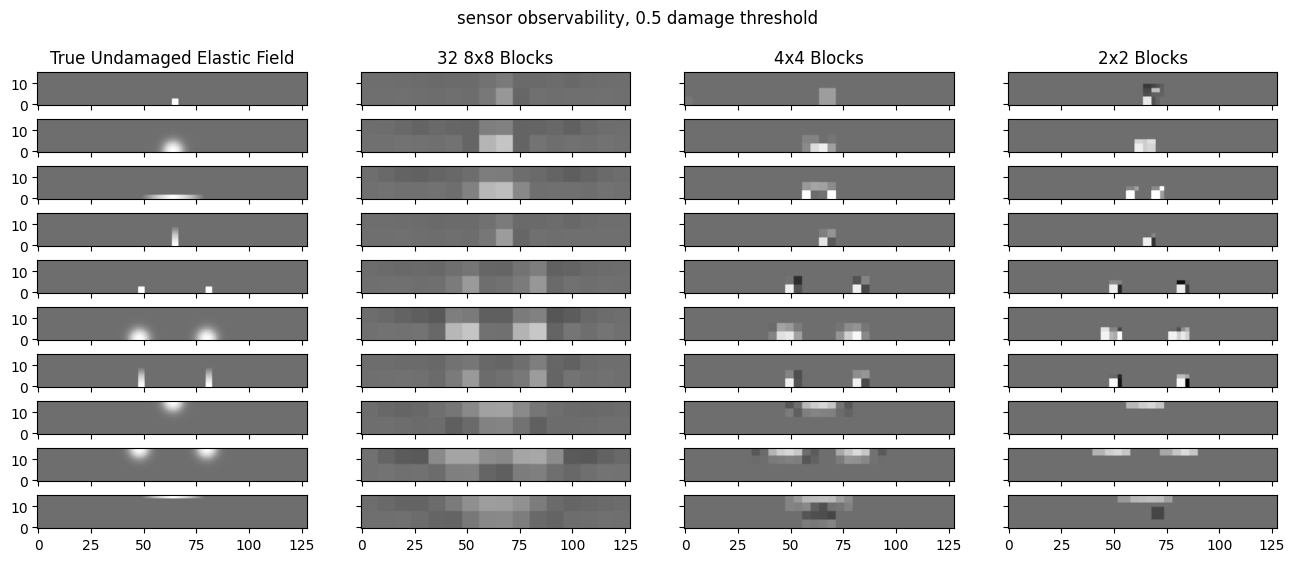

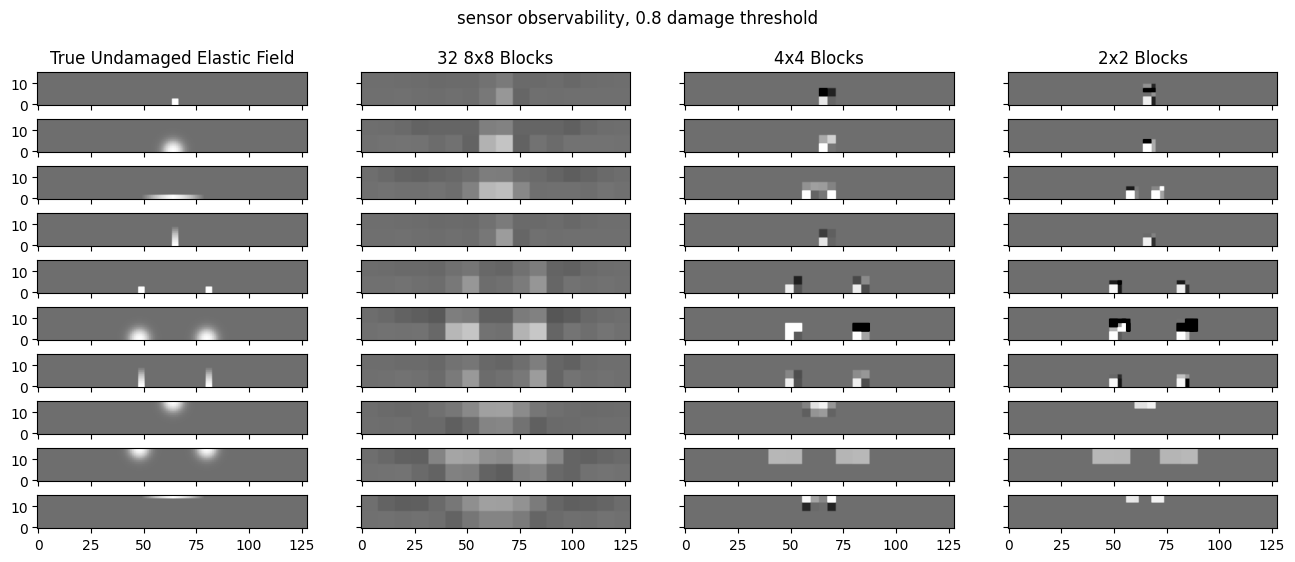

In [34]:



# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

obs_choices = ["full", "sensor"]
cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']
deviation_threshold_list = [0.3, 0.5, 0.8]

obs = 'full'
threshold = 0.5

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 128
Ny = 16
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for obs in obs_choices:
    for threshold in deviation_threshold_list:
        fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


        fig.suptitle(f'{obs} observability, {threshold} damage threshold')

        axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[0, 0].set_title('True Undamaged Elastic Field')
        axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
        # for i in range(10):
        #     axs[i, 0].set_ylabel(str(i))

        for k, case in enumerate(cases):
            filename = [
                f"r_{case}_{obs}_{int(threshold*10)}.json",
            ]
            for z in range(3):
                with open(filename[0]) as json_file:
                    result = json.load(json_file)['results'][z]   
                E = np.zeros(n_particles)
                for i in range(Nx):
                    for j in range(Ny):
                        E[j*Nx+i] = result[i + j * Nx]
                E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
                
                axs[k, z + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

        axs[0, 1].set_title('32 8x8 Blocks')
        axs[0, 2].set_title('4x4 Blocks')
        axs[0, 3].set_title('2x2 Blocks')
        # axs[0, 4].set_title('Individual Particles')
        plt.show()
